In [1]:
import numpy as np
import bagpipes as pipes    
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
import corner
from astropy import units as u
cosmo = LambdaCDM(Om0=0.3, Ode0=0.7, H0=70)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3.5

def M_uv_lim(z, m_lim):
    # assuming a flat spectrum for the K-correction here (e.g. f_nu ~ const or f_lambda ~ lambda^2, e.g. \beta=2, Bouwens+2014, Stefanon+2021)
    return m_lim - 5*np.log10(cosmo.luminosity_distance(z).value*1e6/10 ) + 2.5*np.log10((1+z))

print(M_uv_lim(7,28.8 -2.5*np.log10(3./5.)),M_uv_lim(8,28.8 -2.5*np.log10(3./5.)),M_uv_lim(9,28.23 -2.5*np.log10(3./5.)))

-17.58255368703642 -17.788450374659714 -18.536756891824243


### JAGUAR sources



Number of objects in the 11x11 arcmin^2 Jaguar FoV:  1315


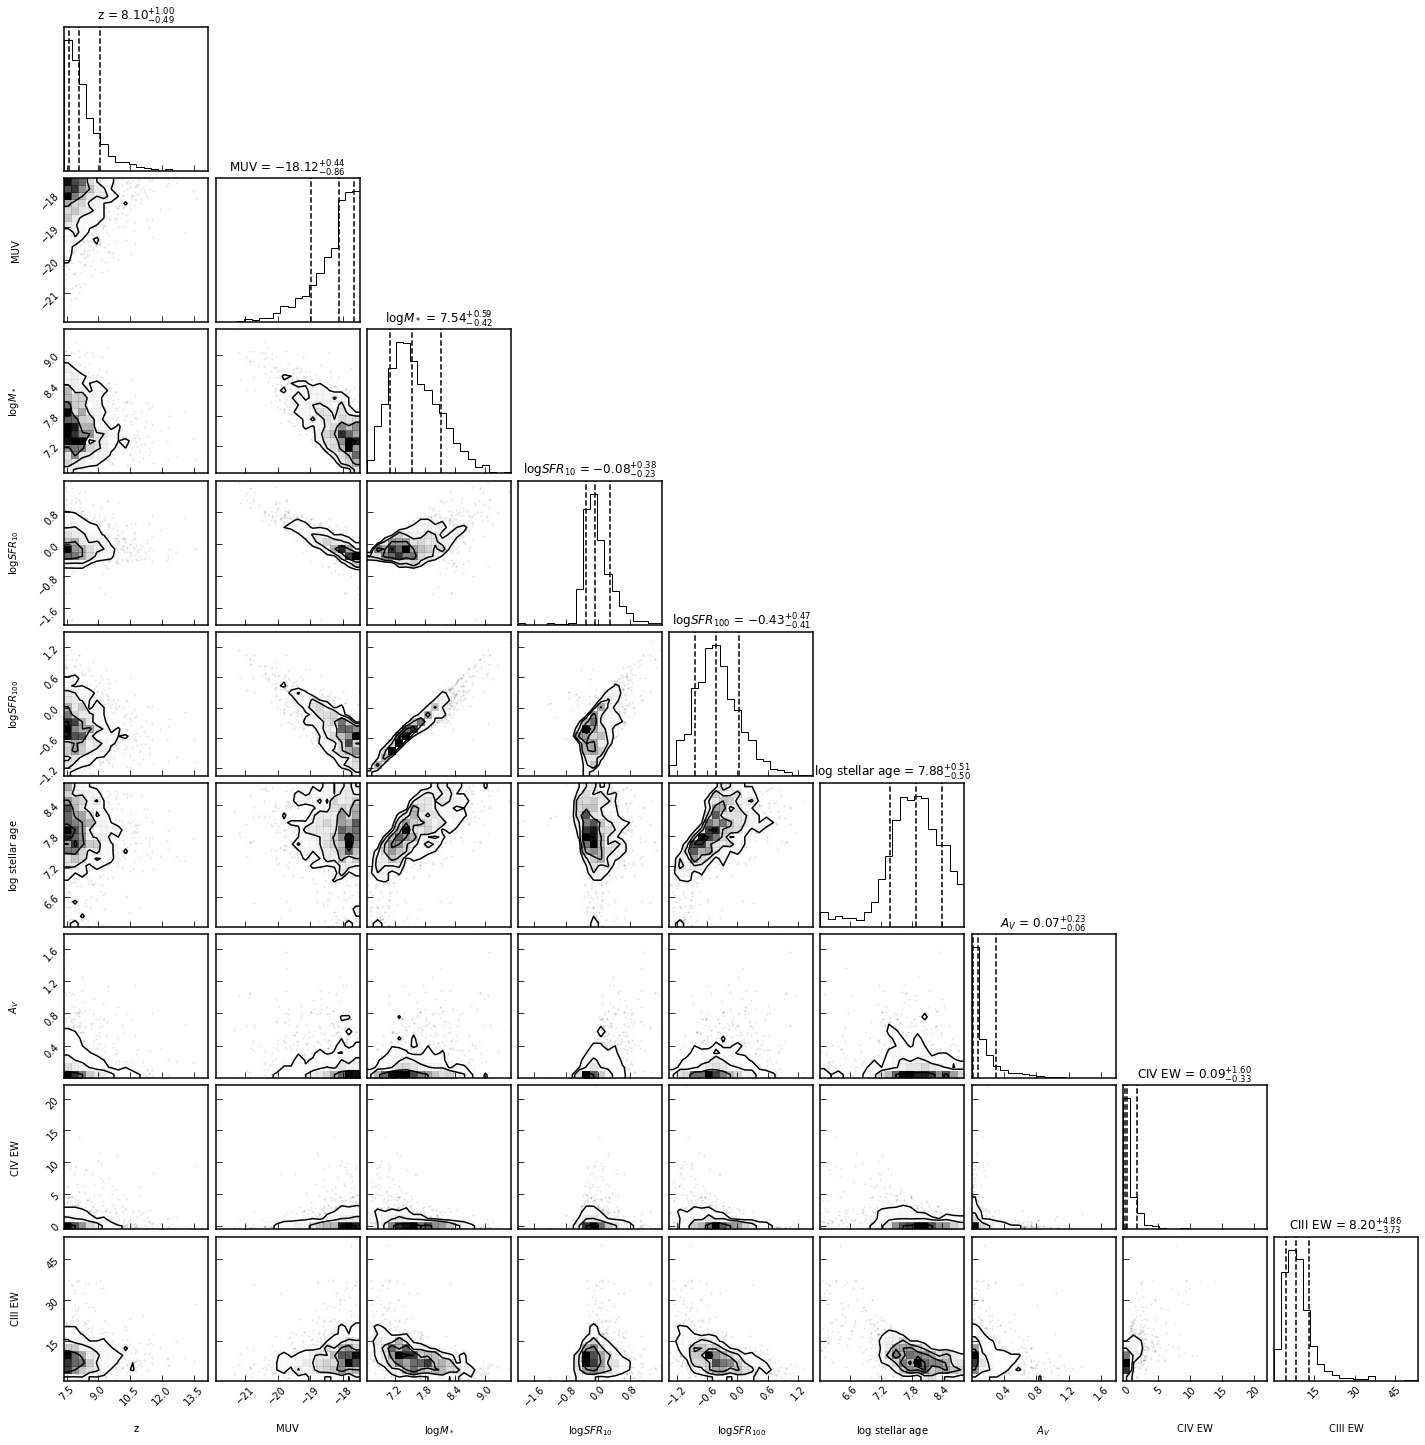

In [2]:
cat_jaguar_properties = fits.open('./JADES_SF_mock_r1_v1.2.fits') #download on Jaguar website: https://fenrir.as.arizona.edu/jaguar/

z_Jag = cat_jaguar_properties[1].data['redshift']
MUV = cat_jaguar_properties[1].data['MUV']
mStar = cat_jaguar_properties[1].data['mStar']
sfr10 = cat_jaguar_properties[1].data['SFR_10']
sfr100 = cat_jaguar_properties[1].data['SFR_100']
max_stellar_age = cat_jaguar_properties[1].data['max_stellar_age']
av = cat_jaguar_properties[1].data['A1500']
C4_EW = cat_jaguar_properties[1].data['C4_1548_1550_EW']
C3_EW = cat_jaguar_properties[1].data['C3_1907_1909_EW']
ID = cat_jaguar_properties[1].data['ID']

ind = np.where( (MUV<-17.5) & (z_Jag>7.4) )[0]

print('Number of objects in the 11x11 arcmin^2 Jaguar FoV: ', len(ind))

highz_galaxies_sample = np.transpose(np.vstack((z_Jag[ind],MUV[ind],mStar[ind],sfr10[ind],sfr100[ind],max_stellar_age[ind],av[ind], C4_EW[ind],C3_EW[ind])))
                   

figure = corner.corner(highz_galaxies_sample,
                      labels=[r"z", r"MUV", r"$\log M_*$",r"$\log SFR_{10}$", r"$\log SFR_{100}$", r"$\log$ stellar age", r"$A_V$", "CIV EW", "CIII EW"],
                      quantiles=[0.16,0.5,0.84], show_titles=True)
plt.show()



#### Quick take-home from Jaguar

- No particular correlations except between redshift, stellar mass and long-term SFR. 
- Two important distributions: MUV and CIV EW. MUV must be kept, but we must sample CIV,CIII EW uniformly to get an estimate of what is possible with NIRISS. CIII should follow as it is correlated.

#### A note on the number of objects

The total number of z>7.4 galaxies with MUV < -17.5 for a Jaguar catalogue is 1315 over 11x11 arcmin. This implies 68 galaxies over the 2.5x2.5 arcmin NIRISS FoV. At MUV<-18, this is only 39 (note the change over only 1/2 dex). This in line with the predictions of the UVLF, as MUV<-18 is really below the detection limits considered in the number prediction notebook. For safety, we will select 68 galaxies even if half are finally not detected in the MIRAGE image. This will help assess the true maximal depth for continuum sources, and bright CIII] sources.

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


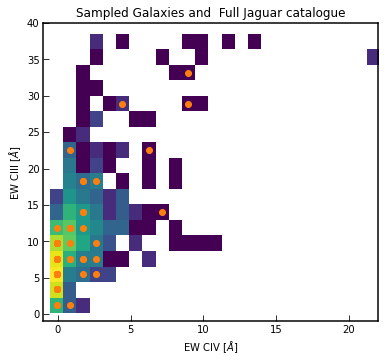

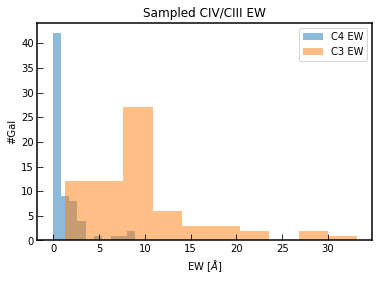

In [3]:
C_Jaguar_binned,xedges, yedges = np.histogram2d(x=C4_EW[ind], y=C3_EW[ind], bins = 25)

C_Jaguar_binned /= np.sum(C_Jaguar_binned)
C4_Jaguar_center = 0.5*(xedges[1:] + xedges[0:-1])
C3_Jaguar_center = 0.5*(yedges[1:] + yedges[0:-1])
C_Jaguar_binned_exist = (C_Jaguar_binned>0) / np.sum(C_Jaguar_binned>0)


Ngal = 68
np.random.seed(8) # choosing a configuration with large-ish spread in CIV

ind_ravel = np.random.choice(np.arange(25*25), size=Ngal, p=C_Jaguar_binned.T.ravel())
ind_unravel = np.unravel_index(ind_ravel,shape=(25,25))

fig = plt.figure(figsize=(6,6))
plt.imshow(np.log10(C_Jaguar_binned).T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],origin='lower',aspect=0.5)
plt.scatter(C4_Jaguar_center[ind_unravel[1]],C3_Jaguar_center[ind_unravel[0]],color='C1')
plt.xlabel(r'EW CIV [$\AA$]')
plt.ylabel(r'EW CIII [$\AA$]')
plt.xlim(-1,22)
plt.ylim(-1,40)
plt.title('Sampled Galaxies and  Full Jaguar catalogue')
plt.show()

plt.hist(C4_Jaguar_center[ind_unravel[1]],10,label='C4 EW',alpha=0.5)
plt.hist(C3_Jaguar_center[ind_unravel[0]],10, label='C3 EW',alpha=0.5)
plt.title('Sampled CIV/CIII EW')
plt.legend()
plt.ylabel('#Gal')
plt.xlabel(r'EW [$\AA$]')
plt.show()

Now that we have a suitable distribution of EW sampling uniformly (in 2D) the parameter space of CIV/CIII EW, let's draw random galaxies corresponding to these properties and check that the MUV, redshift, stellar mass and age correspond to the overall galaxy population.

In [4]:
delta_CIV_EW = np.abs(xedges[1] - xedges[0])/2
delta_CIII_EW = np.abs(yedges[1] - yedges[0])/2

indices_final = []
np.random.seed(4)
for i,j in zip(ind_unravel[1],ind_unravel[0]):
    CIV = C4_Jaguar_center[i]
    CIII = C3_Jaguar_center[j]
    ind_matching_C_EW = np.where( (np.abs(C4_EW[ind]-CIV)<=delta_CIV_EW) & (np.abs(C3_EW[ind]-CIII)<=delta_CIII_EW))[0]

    i = np.random.choice(ind_matching_C_EW)
    indices_final.append(i)


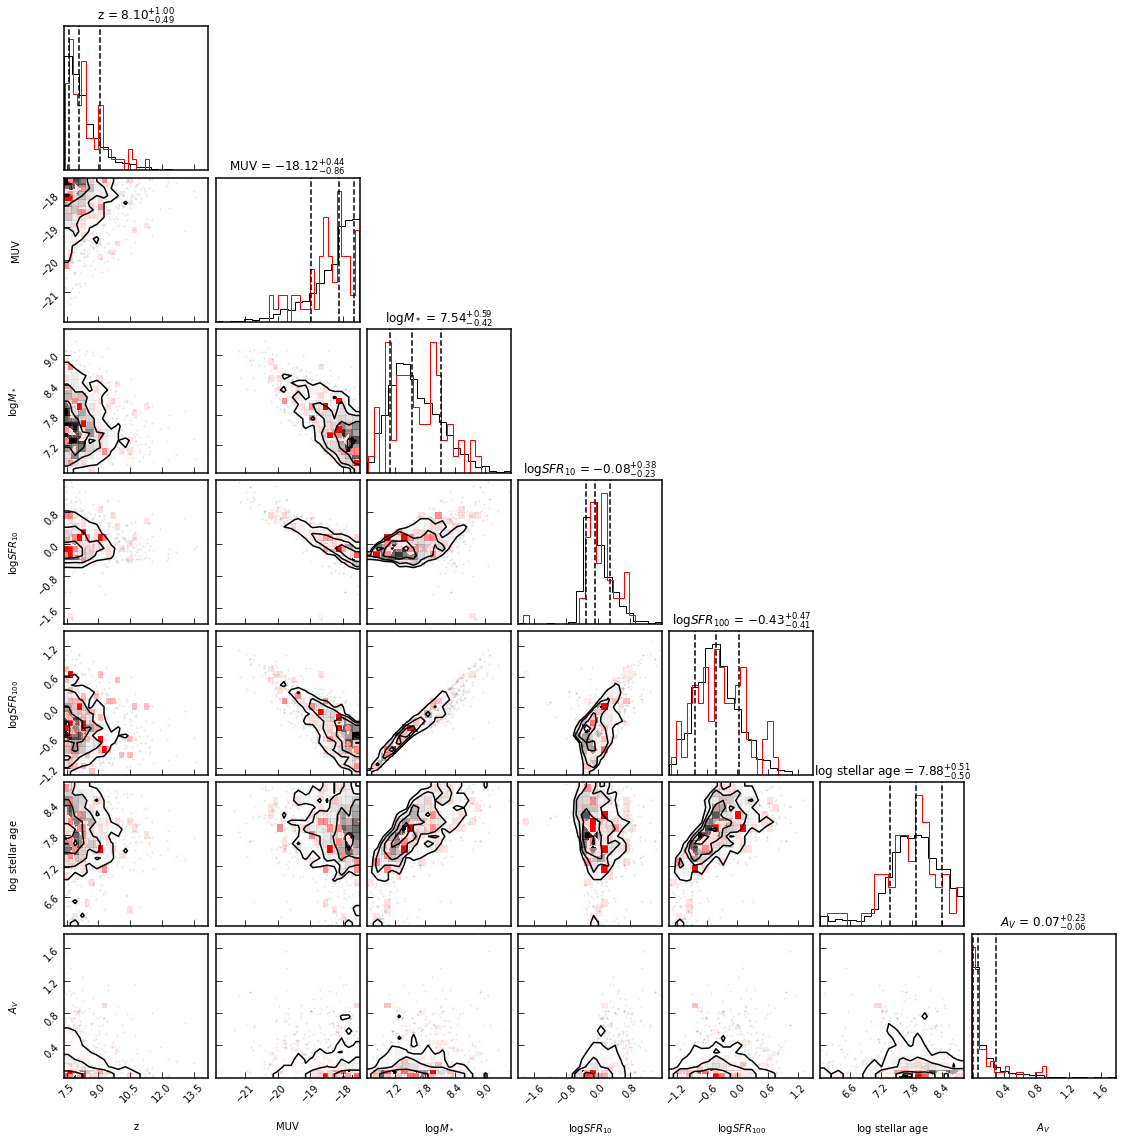

In [5]:
galaxies_sampled = np.transpose(np.vstack((z_Jag[ind][indices_final],MUV[ind][indices_final],mStar[ind][indices_final],sfr10[ind][indices_final],sfr100[ind][indices_final],max_stellar_age[ind][indices_final],av[ind][indices_final])))
                
figure = corner.corner(highz_galaxies_sample[:,:-2],
                      labels=[r"z", r"MUV", r"$\log M_*$",r"$\log SFR_{10}$", r"$\log SFR_{100}$", r"$\log$ stellar age", r"$A_V$"],
                      quantiles=[0.16,0.5,0.84], show_titles=True,hist_kwargs={'density':True})

corner.corner(galaxies_sampled,fig=figure,color='r',hist_kwargs={'density':True},plot_contours=False)
plt.show()


### Properties of the selected sample

All the properties are ~matching the overall distribution, as the number of galaxies sampled (68) is large enough, even though we have fixed the seed to get slightly higher EW(CIV).

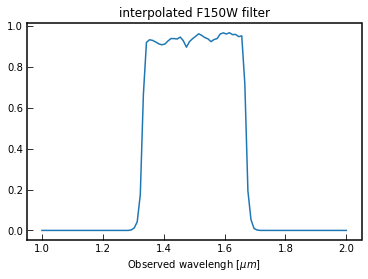

4.033333333333334e-11 erg / (cm2 Hz s)


In [6]:
def transform_and_save_spec_MIRAGE_fmt(wave_ang_rest,flux_lambda_rest,redshift,local_ID):
    wave_micron_obs = wave_ang_rest * (1+redshift) / 1e4 # convert to microns
    flux_lambda_obs = flux_lambda_rest / (1+redshift) # convert to erg/s/cm2/AA OBSERVED
    np.savetxt('./NIRISS_mock_sources_zgtr7p4_spectra/ID'+str(local_ID)+'_no_IGM.spec',np.transpose([wave_micron_obs,flux_lambda_obs]),fmt="%e", header='wl[micron]    flux_l[CGS]')
    
    flux = flux_lambda_rest
    wave = wave_ang_rest
    dwave = wave[1:] - wave[0:-1]
    
    flux_cont = np.mean(flux[np.where((wave>1250) & (wave<1300))[0]])
    flux_Lya = np.sum((flux[np.where((wave>1208) & (wave<1230))[0]]-flux_cont)*dwave[np.where((wave>1208) & (wave<1230))[0]])
    EW_rest = flux_Lya / flux_cont
    
    flux_att = np.copy(flux)
    if flux_Lya > flux_cont:
        flux_att[np.where((wave>1208) & (wave<1230))[0]] = (flux_att[np.where((wave>1208) & (wave<1230))[0]]- flux_cont)*np.random.uniform(0,1) + flux_cont
    flux_Lya = np.sum((flux_att[np.where((wave>1208) & (wave<1230))[0]]-flux_cont)*dwave[np.where((wave>1208) & (wave<1230))[0]])
    EW_att = flux_Lya / flux_cont

    flux_lambda_obs_att = flux_att / (1+redshift) # convert to erg/s/cm2/AA OBSERVED
    np.savetxt('./NIRISS_mock_sources_zgtr7p4_spectra/ID'+str(local_ID)+'_IGM_att.spec',np.transpose([wave_micron_obs,flux_lambda_obs_att]),fmt="%e", header='wl[micron]    flux_l[CGS]')
    
    return mF150W_from_obs_spec(wave_micron_obs,flux_lambda_obs,redshift), EW_rest, EW_att

from scipy.interpolate import interp1d
F150W_filter = np.loadtxt('./filters/JWST_NIRISS.F150W.dat')
F150W_filter_interp = interp1d(F150W_filter[:,0]/1e4,F150W_filter[:,1], kind='linear',fill_value=0,bounds_error=False)

plt.plot(np.linspace(1,2,100),F150W_filter_interp(np.linspace(1,2,100)))
plt.title('interpolated F150W filter')
plt.xlabel(r'Observed wavelengh [$\mu m$]')
plt.show()

flambda_to_fnu_15000A = (u.erg/u.s*(u.cm**(-2))/u.Angstrom*(11000*u.Angstrom*11000*u.Angstrom)/(3e8*u.m*u.Hz)).to(u.erg/u.s*(u.cm**(-2))/u.Hz)
print(flambda_to_fnu_15000A)

def mF150W_from_obs_spec(wave_micron,flux_cgs,redshift):
    dwave_micron = wave_micron[1:]-wave_micron[0:-1]
    flux_lambda_F150W = np.sum(flux_cgs[1:]* F150W_filter_interp(wave_micron[1:]) *dwave_micron) / np.sum(F150W_filter_interp(wave_micron[1:]) *dwave_micron)
    flux_nu_F150W = flux_lambda_F150W*flambda_to_fnu_15000A.value
    mag_F150W = -2.5*np.log10(flux_nu_F150W) -48.60
    return mag_F150W

mF150W 27.97888269999995 9.123685
mF150W 28.252713869246882 9.642631
mF150W 27.667533914985718 7.790479
mF150W 27.5024428289858 7.407458
mF150W 27.818838849939134 7.722238
mF150W 27.95100920701133 7.734298
mF150W 27.463733645712985 7.596197


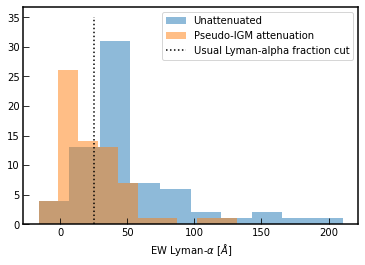

In [7]:
spec = fits.open('JADES_SF_mock_r1_v1.2_spec_5A_30um_z_5_15.fits') #download on Jaguar website: https://fenrir.as.arizona.edu/jaguar/
ind_spec_z5_15 = np.array(spec[3].data['ID'])
counter=1
f = open('./mock_sources_NIRISS_zgtr7p4.txt','w+')
f.write('ID1 RA_offset DEC_offset magF150W Sersic r_eff axis_ratio PA redshift mass ID2 ID3 no1 no2 \n')

np.random.seed(1)

EW_array= []

for index in indices_final:
    i = np.where(ind_spec_z5_15 == ID[ind][index])[0][0]
    m,EW_rest, EW_att = transform_and_save_spec_MIRAGE_fmt(wave_ang_rest=spec[2].data,flux_lambda_rest=spec[1].data[i], redshift=z_Jag[ind][index], local_ID=counter)
    EW_array.append([EW_rest,EW_att])
    if m<28.3:
        print('mF150W', m,z_Jag[ind][index])

    offsets = np.random.uniform(-1.55,1.55,size=2)*60
    
    f.write(str(counter)+ ' ' + str(offsets[0]) + ' ' +  str(offsets[1]) + ' ' + str(m) + ' ' + 
            str(4) + ' ' + str(0.05) + ' ' + str(1) + ' ' + str(0) + ' ' + # sersic, r_eff, axis_ratio, PA
            str(z_Jag[ind][index]) + ' ' + str(mStar[ind][index]) + ' ' + str(ID[ind][index]) +
            ' 1 1 1 \n')  # additional unused IDs 
    
    counter+=1
    
f.close()

EW_array = np.array(EW_array)
plt.hist(EW_array[:,0],label='Unattenuated',alpha=0.5)
plt.hist(EW_array[:,1],label='Pseudo-IGM attenuation',alpha=0.5)
plt.vlines(x=[25],ymin =0,ymax=35,linestyle=':',color='k', label='Usual Lyman-alpha fraction cut')
plt.xlabel(r'EW Lyman-$\alpha$ [$\AA$]')
plt.legend()
plt.show()

np.savetxt('./EW_mock_sources_NIRISS_zgtr7p4.txt',np.transpose([np.arange(1,Ngal+1),EW_array[:,0],EW_array[:,1]]),header='ID EW_rest[\AA] EW_att[\AA]')


This makes 7 galaxies with mag_F150W=28.3 in the NIRISS FoV, in agreement with the prediction from the UVLF (6 - over 2.2x2.2 arcmin instead of 2.5x2.5.

## NOTE on the IGM attenuation

The Lyman-alpha IGM attenuation is a completely fictious one! It is meant to offset the distribution towards more plausible values, getting a majority of sources with a Lyman-alpha too weak to be detected in the field, but with still a few that will be used to compute the Lyman-alpha fraction. This is in rough accordance with the number predicted in the NIRISS_Highz_Expectations and previous studies on the Lyman-alpha fraction.
